# Car price prediction


## Table of content

1. Introduction
2. Data Exploration
3. Feature engineering
4. Data Cleaning and Feature Engineering
5. Model Building
6. Results and Discussion

## 1. Introduction 

This project involves building a price prediction project for vehicle prices. The problem that we have at hand is a supervised learning problem. The dependant variable is a continuous variable which makes this a regression problem. In order to get a better view of how to approach this problem and what tools to use we will explore the dataset thoroughly.

The required libraries are loaded below.



In [46]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from datetime import datetime
from sklearn.model_selection import train_test_split
from scipy.stats import norm, skew
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PowerTransformer, LabelEncoder
import lightgbm as lgb
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import Ridge
from tabulate import tabulate
import joblib
import optuna
import pickle

## 2. Data exploration

In this step we will do a number of steps to explore the data and understand the data better. This will help us in the modelling and downstream steps. First we will see the first few records in the dataset, then look at the data tyes, we inspect the size of the dataset, explore numerical columns and get a count of the null values. 

In [45]:
price = pd.read_csv("price.csv")
price[0:10]

,car_brand,car_model,car_variant,car_year,car_engine,car_transmission,milage,accident,flood,color,purchase_date,sales_date,price
0,b51026e4444f98ecdbe1d7cb1f310427a47d7a6e7659b3...,4539e4b4889079c2a00afeae0bfc1439840ef2379a1fb8...,b20b25f3d8e86acc926ec233aac7485058f71a82cbb6f8...,2010,2.0,Auto,282508,1,0,blue,22/08/20,2/10/2020,30100
1,b51026e4444f98ecdbe1d7cb1f310427a47d7a6e7659b3...,4539e4b4889079c2a00afeae0bfc1439840ef2379a1fb8...,1dff83b33d877727a06f16e2d53e96834dccb80af01f8e...,2010,1.8,Auto,169475,1,0,black,4/9/2020,9/12/2020,32100
2,b51026e4444f98ecdbe1d7cb1f310427a47d7a6e7659b3...,4539e4b4889079c2a00afeae0bfc1439840ef2379a1fb8...,1dff83b33d877727a06f16e2d53e96834dccb80af01f8e...,2010,1.8,Auto,105276,0,0,white,17/05/20,25/08/20,34100
3,b51026e4444f98ecdbe1d7cb1f310427a47d7a6e7659b3...,4539e4b4889079c2a00afeae0bfc1439840ef2379a1fb8...,bc8c75c6d926e32a4dd2119e279211bae53ad4024822c4...,2010,2.0,Auto,81123,0,0,black,16/01/20,8/5/2020,40100
4,b51026e4444f98ecdbe1d7cb1f310427a47d7a6e7659b3...,4539e4b4889079c2a00afeae0bfc1439840ef2379a1fb8...,1dff83b33d877727a06f16e2d53e96834dccb80af01f8e...,2013,1.8,Auto,157239,1,0,brown,20/10/20,7/12/2020,42000
5,b51026e4444f98ecdbe1d7cb1f310427a47d7a6e7659b3...,4539e4b4889079c2a00afeae0bfc1439840ef2379a1fb8...,1dff83b33d877727a06f16e2d53e96834dccb80af01f8e...,2013,1.8,Auto,170215,1,0,white,15/06/20,14/09/20,50500
6,b51026e4444f98ecdbe1d7cb1f310427a47d7a6e7659b3...,4539e4b4889079c2a00afeae0bfc1439840ef2379a1fb8...,37785b2033c7db36c8d8976511068c240465f6adf516a7...,2013,1.8,Auto,192647,0,0,grey,27/09/19,24/10/19,55100
7,b51026e4444f98ecdbe1d7cb1f310427a47d7a6e7659b3...,4539e4b4889079c2a00afeae0bfc1439840ef2379a1fb8...,37785b2033c7db36c8d8976511068c240465f6adf516a7...,2013,1.8,Auto,81127,0,0,white,1/12/2019,5/3/2020,57400
8,b51026e4444f98ecdbe1d7cb1f310427a47d7a6e7659b3...,4539e4b4889079c2a00afeae0bfc1439840ef2379a1fb8...,1dff83b33d877727a06f16e2d53e96834dccb80af01f8e...,2013,1.8,Auto,171512,1,0,red,4/5/2020,8/7/2020,58800
9,b51026e4444f98ecdbe1d7cb1f310427a47d7a6e7659b3...,4539e4b4889079c2a00afeae0bfc1439840ef2379a1fb8...,1dff83b33d877727a06f16e2d53e96834dccb80af01f8e...,2013,1.8,Auto,98656,0,0,black,25/09/20,4/11/2020,60300


In [3]:
# convert the relevant columns to boolian

price = price.astype({'flood': bool, 'accident': bool}) 

In [4]:
print("The car price dataset has ",price.shape[0]," rows")
print("The car price dataset has ",price.shape[1]," columns")

The car price dataset has  95426  rows
The car price dataset has  13  columns


In [5]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

numeric_cols = []

for i in price.columns:
    if price[i].dtype in numeric_dtypes:
        numeric_cols.append(i)
        
price[numeric_cols].describe().loc[['mean','50%','std','min', "max"]].round(2)

,car_year,car_engine,milage,price
mean,2011.37,1.66,147804.27,32200.76
50%,2012.00,1.60,133479.00,23700.00
std,4.26,0.43,85450.08,29758.71
min,1981.00,0.60,1.00,400.00
max,2020.00,8.00,992910.00,1000800.00


In [6]:
price.isnull().sum()

car_brand           0
car_model           2
car_variant         0
car_year            0
car_engine          0
car_transmission    0
milage              0
accident            0
flood               0
color               0
purchase_date       0
sales_date          0
price               0
dtype: int64

In [7]:
price.loc[:, ~price.columns.isin(numeric_cols)].columns

Index(['car_brand', 'car_model', 'car_variant', 'car_transmission', 'accident',
       'flood', 'color', 'purchase_date', 'sales_date'],
      dtype='object')

Explore the distribution of numeric columns in the dataset

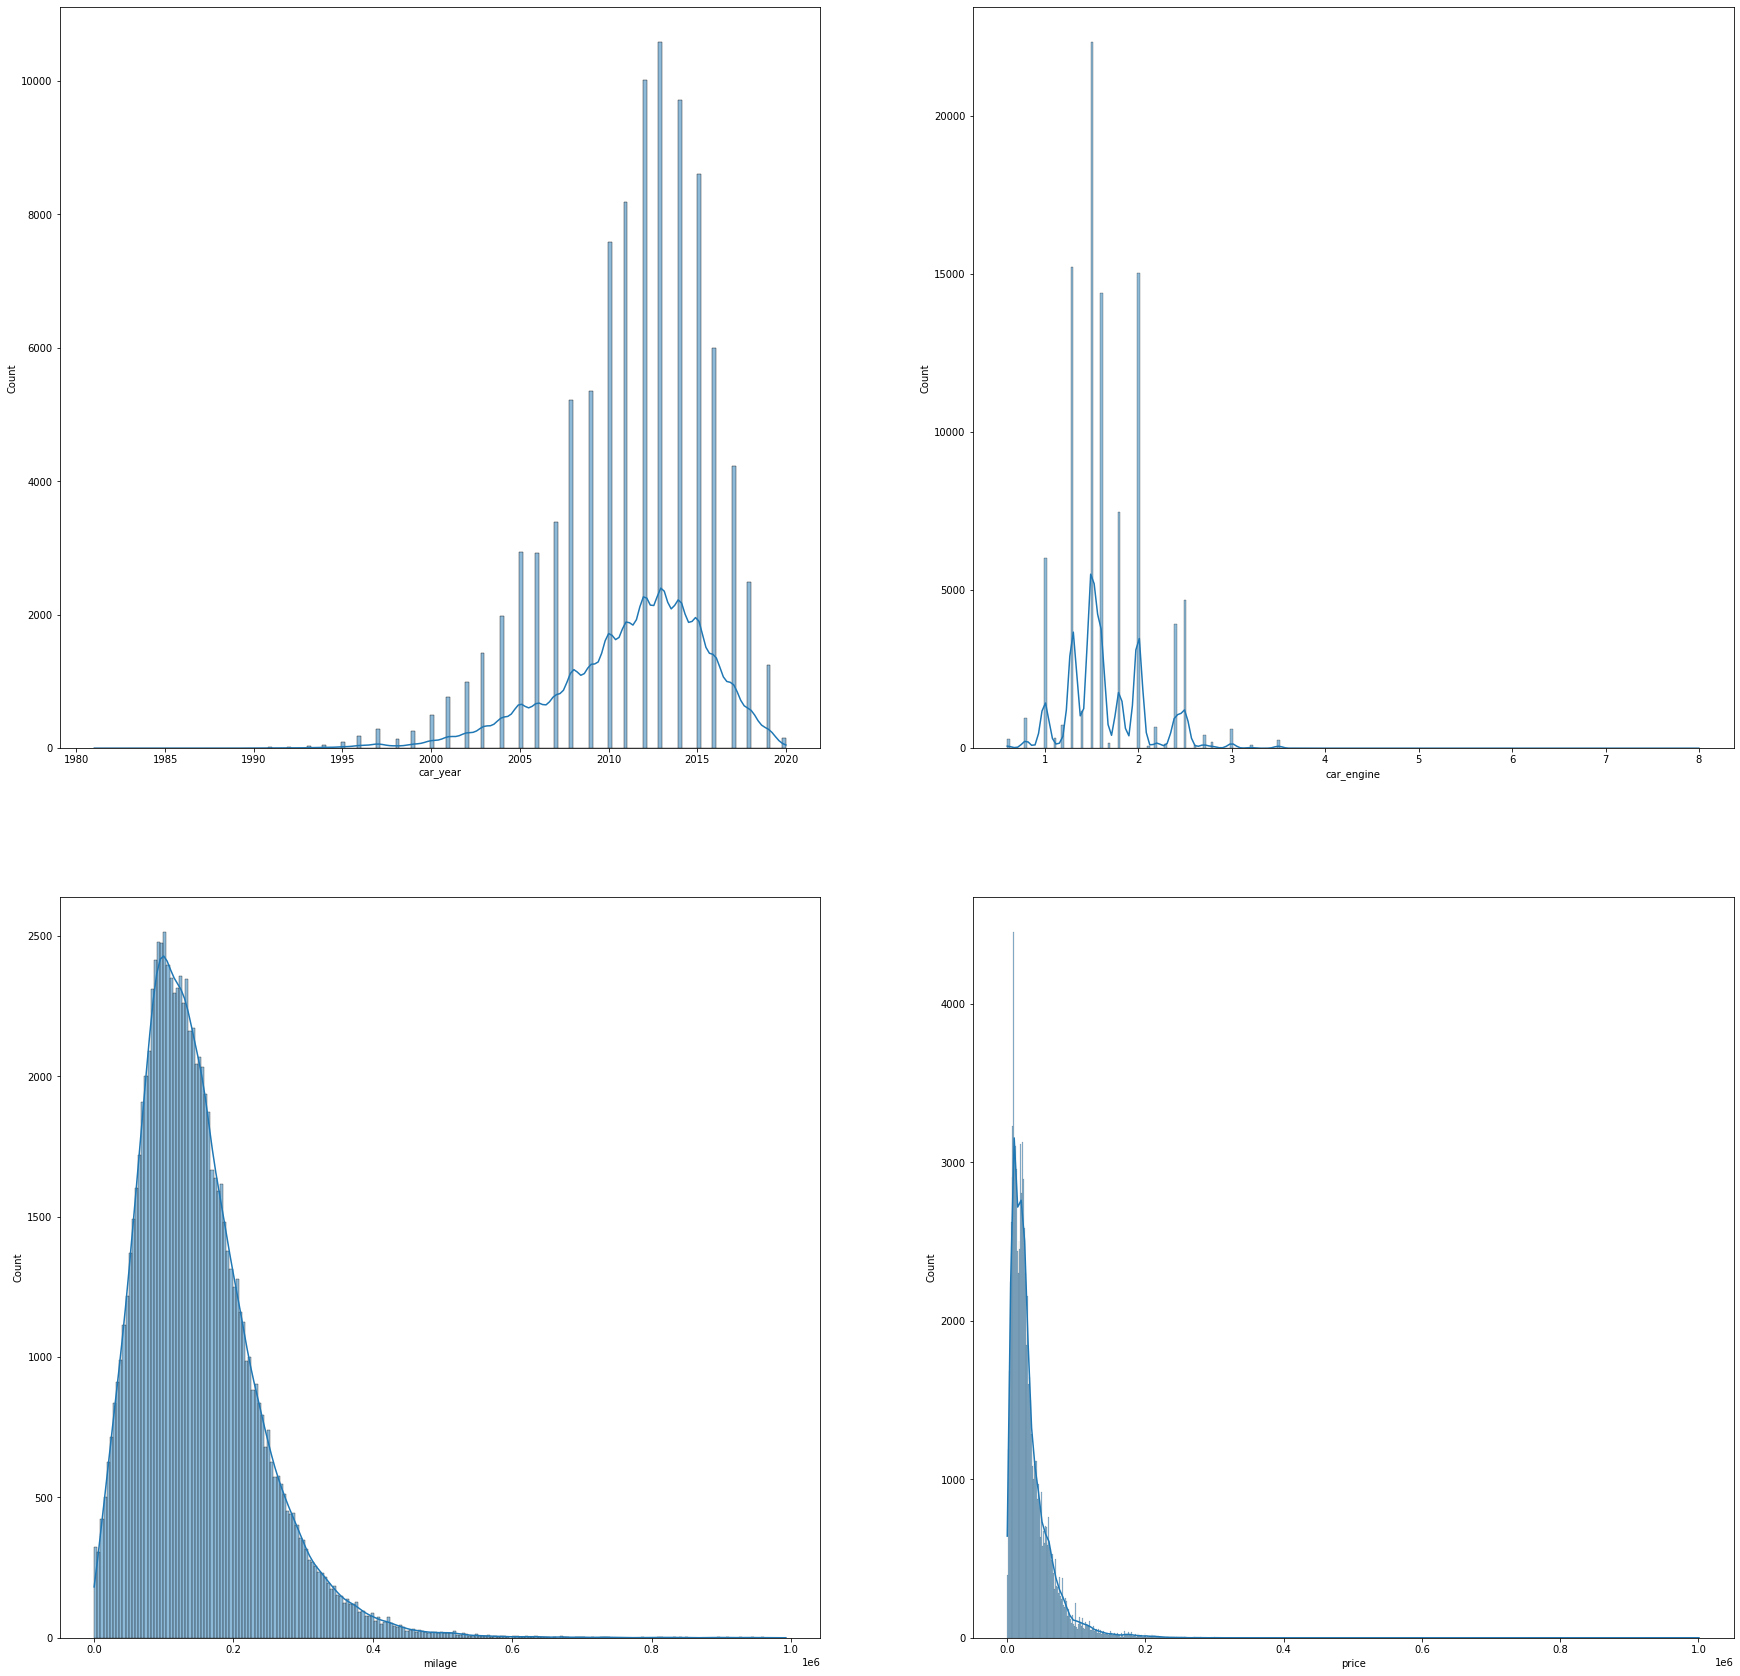

In [8]:
n_rows=2
n_cols=2

# Create the subplots

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(30, 30), sharex=False)

for i, column in enumerate(numeric_cols):
    sns.histplot(price[column],ax=axes[i//n_cols,i%n_cols], kde=True)
 

In [9]:
price.loc[:, ~price.columns.isin(numeric_cols)].columns

Index(['car_brand', 'car_model', 'car_variant', 'car_transmission', 'accident',
       'flood', 'color', 'purchase_date', 'sales_date'],
      dtype='object')

In [10]:
cat_cols = ['car_brand','car_model','car_variant','car_transmission','accident','flood','color']


for i in cat_cols:
#     print(i)
    print("The column " , i, " has ",  price[i].nunique(), " unique values") 


The column  car_brand  has  31  unique values
The column  car_model  has  219  unique values
The column  car_variant  has  2279  unique values
The column  car_transmission  has  2  unique values
The column  accident  has  2  unique values
The column  flood  has  2  unique values
The column  color  has  16  unique values


There are few insights that we can gather from the data exploration.
1. Certain numeric variables such as Price, milage contain very extreme values. The model will be better off by removing the outliers.
2. The categorical columns such as car brand, car model, car varient seem to have too many varients. There could be levels that do not contribute to the importance of the model much. Removing some of these will greatly reduce computing requirements.
3. There are not too many null values for us to impute. We can safely impute these figures with mode.
4. The columns that contain date is in different formats. Converting this to a date format may not be  straightforward. 

## 2. Data cleaning

There are few adjustments to the dataset we want to do upon looking at the data exploration part.

There are two missing values. We can safely impute them with mode without much impact to the model.

In [11]:
price2 = price.copy()

price2['car_model'] = price2['car_model'].fillna(price2['car_model'].mode()[0])

In the data exploration part we saw that specific columns such as milage and car engine has outlier values. We can replace these extreme values with median

In [12]:

def replace_outliers_with_median(series):
    median = series.median()
    std = series.std()
    outliers = (series - median).abs() > 3.5 * std
    series[outliers] = median
    return series


subset_cols = ['milage', 'car_engine','price']
price2[subset_cols] = price2[subset_cols].apply(replace_outliers_with_median)

## 3. Feature engineering

The categorical columns have a lot of different levels that a model may not be able to handle and it will become potentially expensive in terms of computation. For this reason, I decide to encode all the values that contribute to less than 1%. I made this decision as their existance in the model will not serve much purpose. For example, such feature with less than 1% of occurences have very little varience in the data and therefore will hardly contribute to the model. I encode them as "other" categories. 

In [13]:
price2 = price.copy()

cat_cols2 = ['car_brand','car_model','car_variant','color']

for i in cat_cols2:
    drop_cats = price2[i].value_counts(normalize=True).loc[lambda x: x < 0.01].index
    price2.loc[price2[i].isin(drop_cats), i] = 'other_' + i
    

Here, we will fix the datetime and extract information out of it. As we saw earlier, the dates are not in a common format which needs to first get to a unified format. Once we create the date columns in proper formats, we will create columns such as car age, purchase year out of the date columns available.

In [14]:
def convert_date(date_str):
    try:
        return datetime.strptime(date_str, '%d/%m/%y')
    except ValueError:
        return datetime.strptime(date_str, '%d/%m/%Y')

In [15]:
# Fix the date columns and create related features

price2['purchase_date'] = price2['purchase_date'].apply(convert_date)
price2['sales_date'] =  price2['sales_date'].apply(convert_date)

# held time feature 
price2['held_time'] = (price2['sales_date'] - price2['purchase_date']).dt.days.astype(int)
price2['purchase_year'] = (price2['purchase_date'].dt.year)

# car age feature
price2['car_age'] = price2['purchase_year'] - price2['car_year']


In [16]:
# Getting squared value for car age
price2['car_age_sq'] = (price2['car_age'])**2

# Getting squared value for milage
price2['milage_sq'] = (price2['milage'])**2

# binning the milage column
price2['milage_bin'] = pd.qcut(price2['milage'].rank(method='first'), 5,labels = [1,2,3,4,5]).astype('int')

# milage per spent year
price2['milage_per_yr'] = price2['milage']/(price2['car_age']+1)
median = price2['milage_per_yr'].replace([np.inf, -np.inf], np.nan).median()
price2['milage_per_yr'] = price2['milage_per_yr'].replace([np.inf, -np.inf], median)

# before or after covid 
price2['purchase_date_binary_1'] = np.where(price2['purchase_date']>"2020-03-01",1,0)

# how recent the car is
price2['car_year_min'] = price2['car_year']-np.min(price2['car_year'])

# car year distance from median
price2['car_year_dist'] = price2['car_year']-np.median(price2['car_year'])

In [17]:
price2[0:20]

,car_brand,car_model,car_variant,car_year,car_engine,car_transmission,milage,accident,flood,color,...,held_time,purchase_year,car_age,car_age_sq,milage_sq,milage_bin,milage_per_yr,purchase_date_binary_1,car_year_min,car_year_dist
0,other_car_brand,other_car_model,other_car_variant,2010,2.0,Auto,282508,True,False,blue,...,41,2020,10,100,79810770064,5,25682.545455,1,29,-2.0
1,other_car_brand,other_car_model,other_car_variant,2010,1.8,Auto,169475,True,False,black,...,96,2020,10,100,28721775625,4,15406.818182,1,29,-2.0
2,other_car_brand,other_car_model,other_car_variant,2010,1.8,Auto,105276,False,False,white,...,100,2020,10,100,11083036176,2,9570.545455,1,29,-2.0
3,other_car_brand,other_car_model,other_car_variant,2010,2.0,Auto,81123,False,False,black,...,113,2020,10,100,6580941129,2,7374.818182,0,29,-2.0
4,other_car_brand,other_car_model,other_car_variant,2013,1.8,Auto,157239,True,False,brown,...,48,2020,7,49,24724103121,4,19654.875000,1,32,1.0
5,other_car_brand,other_car_model,other_car_variant,2013,1.8,Auto,170215,True,False,white,...,91,2020,7,49,28973146225,4,21276.875000,1,32,1.0
6,other_car_brand,other_car_model,other_car_variant,2013,1.8,Auto,192647,False,False,grey,...,27,2019,6,36,37112866609,4,27521.000000,0,32,1.0
7,other_car_brand,other_car_model,other_car_variant,2013,1.8,Auto,81127,False,False,white,...,95,2019,6,36,6581590129,2,11589.571429,0,32,1.0
8,other_car_brand,other_car_model,other_car_variant,2013,1.8,Auto,171512,True,False,red,...,65,2020,7,49,29416366144,4,21439.000000,1,32,1.0
9,other_car_brand,other_car_model,other_car_variant,2013,1.8,Auto,98656,False,False,black,...,40,2020,7,49,9733006336,2,12332.000000,1,32,1.0


Once the feature engineering is done we will visualize the correlation plot. The data correlation will show you an early idea about what sort of a dataset we are dealing with. It will show what variables correlate heavily with our target variables and which variables could cause a collenearity problem/ redundent variables.

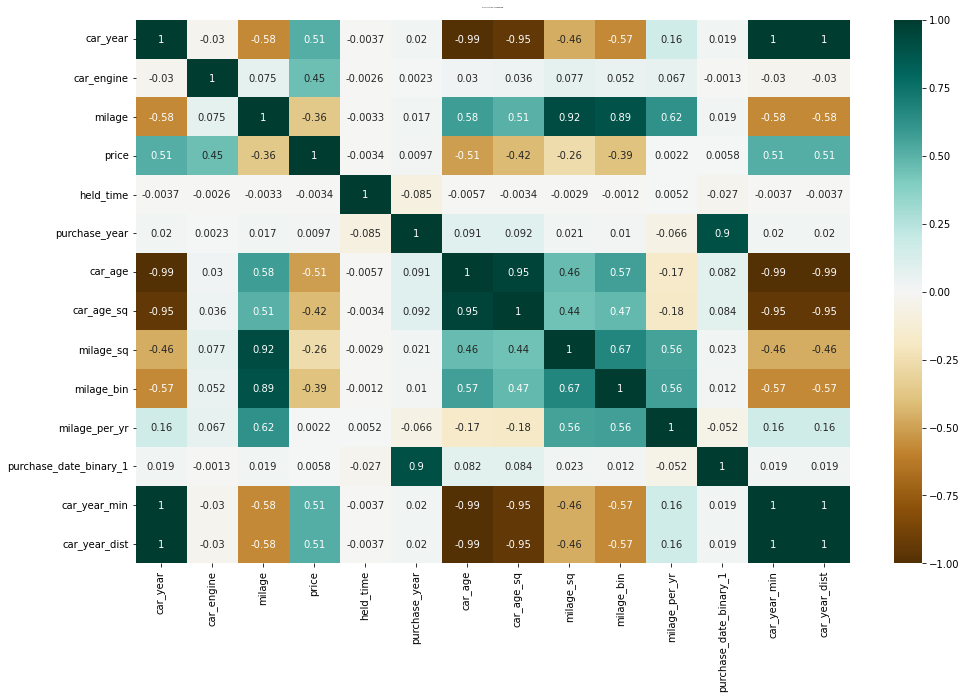

In [18]:

numeric_cols2 = []

for i in price2.columns:
    if price2[i].dtype in numeric_dtypes:
        numeric_cols2.append(i)
        
plt.figure(figsize=(16, 10))

heatmap = sns.heatmap(price2[numeric_cols2].corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':2}, pad=12);        

As we can see there are some variables that strongly correlate with the target variable and we can also see that some variables have strong inter-correlation especially the ones we have created. we will need to perform feature selection in order to arrive at a robust model.

We will drom the date columns as they do not serve a purpose anymore in prediction.

In [19]:
drop_cols = ['purchase_date','sales_date']

price2 = price2[price2.columns.drop(drop_cols)]

In [20]:
price2 = pd.get_dummies(price2).reset_index(drop=True)

## 4. Feature selection

Now that we have created a number of features, it is important to select the features that are only relevant to predict out of all the available features. This will greatly reduce the computing requirements and make a very explainable model. We will use select from a random forest model. It uses feature importance to select relevant features which will give us a set of variables that helps to reduce the error the most. This suits our analysis as this is a very fast algorithm compared to backward feature elemination or forward feature selection. 

In [21]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor

x_slct = price2[price2.columns.drop('price')]
y_slct = price2['price']

rf = RandomForestRegressor()
rf.fit(x_slct, y_slct)

selector = SelectFromModel(rf, prefit=True)


In [22]:
selector.fit(x_slct, y_slct)


SelectFromModel(estimator=RandomForestRegressor(), prefit=True)

In [23]:
selected_feat= x_slct.columns[(selector.get_support())]
print(selected_feat)

Index(['car_year', 'car_engine', 'milage', 'held_time', 'car_age',
       'car_age_sq', 'milage_sq', 'milage_per_yr', 'car_year_min',
       'car_year_dist',
       'car_brand_27df9ed9a477af0fcfe369c8ef3474a75cebf357d8b421ca40f1de6cfd4cbb06',
       'car_brand_337b8d2c1e132acd75171f1acf0e73b20bc9541720d5003813f59ef0ad51f86f',
       'car_brand_8417659f46b5b43b2bb9396f794ab19728546f699babdb914d97bc5adcb9f528',
       'car_brand_eaac0f48d2ccec4d9cfca2115cb16800ecd23f60265f0ca0995ef41b8c55ac60',
       'car_model_other_car_model'],
      dtype='object')


In [24]:
# train test split: We do a 80:20 split

In [25]:
_test_size = 0.20
_random_seed = 1234


x = price2[selected_feat]
y = price2['price']
x_train, x_test, y_train, y_test = train_test_split(x, y , test_size=_test_size, random_state=_random_seed)

## 6. Modelling

In the modelling section we will test out 3 advanced models. This problem is a regression machine learning problem. I have chosen a set of classic and more advanced algorithms of machine learning used for regression. All the models used here are known to perfom well in similar forecasting problems. 

1. Ridge regression
2. Random forest model.
3. LightGBM model.

For all the models we will tune parameters using cross validation accuracies. First we will set up our cross-validation platform. We perform 10 fold cross validation here in order to tune the parameters.



In [26]:
# 10-fold CV
kfolds = KFold(n_splits=10, shuffle=True, random_state=_random_seed)

In [27]:
def tune(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score} \nOptimized parameters: {params}")
    
    return params

### 6.1. Ridge regression

Ridge regression is very similar to OLS regression. In OLS regression it tries to find the line that minimizes the sum of squared error. In addition to that in ridge regression adds a regularization parameter to reduce overfitting. It may not be very accurate compared to more state-of-the-art methods but a good method to expeirment with. We will tune the parameter alpha which shrinks the coefficients. It is particularly appropriate as we observed inter-relationships between variables.

In [28]:
def ridge_objective(trial):
    
    alpha = trial.suggest_uniform("alpha", 0.0, 10.0)

    reg = Ridge(alpha=alpha)

    score = cross_val_score(
        reg, x_train, y_train, cv=kfolds, scoring="neg_mean_squared_error"
    )

    return -score.mean()

study = optuna.create_study(direction="minimize")
study.optimize(ridge_objective, n_trials=100)

best_params = study.best_params

[I 2023-03-09 17:12:02,492] A new study created in memory with name: no-name-a53cad8a-b266-4889-8d82-16a847eeba98
<ipython-input-28-054d4775fb6b>:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  alpha = trial.suggest_uniform("alpha", 0.0, 10.0)
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.15534e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.20818e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\l

c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.00702e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.00741e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
[I 2023-03-09 17:12:03,287] Trial 2 finished with value: 266328136.61728272 and parameters: {'alpha': 0.5332777594500782}. Best is trial 2 with value: 266328136.61728272.
<ipython-input-28-054d4775fb6b>:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  alpha = trial.suggest_uniform("alpha", 0.0, 10.0)
c

c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.15817e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.13923e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.21189e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.15411e-25): result may not be accurate.
  return lina

c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.57964e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.67084e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.58251e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.54237e-25): result may not be accurate.
  return lina

<ipython-input-28-054d4775fb6b>:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  alpha = trial.suggest_uniform("alpha", 0.0, 10.0)
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.43591e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.49345e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.40466e-27): re

c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.85701e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.75627e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.75673e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
[I 2023-03-09 17:12:06,130] Trial 13 finished with value: 266329955.10427317 and parameters: {'alpha': 6.692314641240758}. Best is trial 11 with value: 266328131.9435586.
<ipython-input-28-054d4775fb6b>:3: Futur

c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.21561e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.19266e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.18218e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.22235e-27): result may not be accurate.
  return lina

c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.15018e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.17559e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.3382e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.1807e-26): result may not be accurate.
  return linalg

<ipython-input-28-054d4775fb6b>:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  alpha = trial.suggest_uniform("alpha", 0.0, 10.0)
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.77426e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.8877e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.71262e-26): res

c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.56845e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.56865e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
[I 2023-03-09 17:12:09,010] Trial 24 finished with value: 266328424.43704677 and parameters: {'alpha': 2.7862694183257255}. Best is trial 21 with value: 266328131.57399827.
<ipython-input-28-054d4775fb6b>:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  alpha = trial.suggest_uniform("alpha", 0.0, 10.0)

c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.64746e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.57858e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.54714e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.66768e-27): result may not be accurate.
  return lina

c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.46199e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.37392e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.38447e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.45184e-25): result may not be accurate.
  return lina

<ipython-input-28-054d4775fb6b>:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  alpha = trial.suggest_uniform("alpha", 0.0, 10.0)
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.6774e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.72224e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.65305e-27): res

c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.49448e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.49506e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
[I 2023-03-09 17:12:11,847] Trial 35 finished with value: 266328147.65622264 and parameters: {'alpha': 0.7972274105235699}. Best is trial 21 with value: 266328131.57399827.
<ipython-input-28-054d4775fb6b>:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  alpha = trial.suggest_uniform("alpha", 0.0, 10.0)

c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.73013e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.69737e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.823e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.72314e-26): result may not be accurate.
  return linalg

c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.07608e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.08255e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.12396e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.08385e-27): result may not be accurate.
  return lina

<ipython-input-28-054d4775fb6b>:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  alpha = trial.suggest_uniform("alpha", 0.0, 10.0)
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.13439e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.18688e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.10588e-26): re

c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.77895e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.77996e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
[I 2023-03-09 17:12:14,718] Trial 46 finished with value: 266328193.4283905 and parameters: {'alpha': 1.380430616182452}. Best is trial 21 with value: 266328131.57399827.
<ipython-input-28-054d4775fb6b>:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  alpha = trial.suggest_uniform("alpha", 0.0, 10.0)
c

c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.31888e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.30731e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.35172e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.31641e-25): result may not be accurate.
  return lina

c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.32547e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.29179e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.29581e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.32158e-27): result may not be accurate.
  return lina

<ipython-input-28-054d4775fb6b>:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  alpha = trial.suggest_uniform("alpha", 0.0, 10.0)
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.00942e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.02632e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.00023e-25): re

c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.75135e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.75192e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
[I 2023-03-09 17:12:17,574] Trial 57 finished with value: 266331085.2952579 and parameters: {'alpha': 8.476434709498736}. Best is trial 56 with value: 266328131.35458237.
<ipython-input-28-054d4775fb6b>:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  alpha = trial.suggest_uniform("alpha", 0.0, 10.0)
c

c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.08642e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.06809e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.13836e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.08251e-26): result may not be accurate.
  return lina

c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.71767e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.54691e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.56732e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.69793e-26): result may not be accurate.
  return lina

<ipython-input-28-054d4775fb6b>:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  alpha = trial.suggest_uniform("alpha", 0.0, 10.0)
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.1534e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.30668e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.07009e-26): res

c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.81631e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.76887e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.7691e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
[I 2023-03-09 17:12:20,431] Trial 68 finished with value: 266328132.0343635 and parameters: {'alpha': 0.3136464350529041}. Best is trial 56 with value: 266328131.35458237.
<ipython-input-28-054d4775fb6b>:3: Futur

c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.57789e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.56402e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.61717e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.57493e-26): result may not be accurate.
  return lina

c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.84772e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.81282e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.7969e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.85796e-26): result may not be accurate.
  return linal

c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.11256e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.10279e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.14026e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.11047e-25): result may not be accurate.
  return lina

c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.13991e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.16258e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.14062e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.1306e-26): result may not be accurate.
  return linal

<ipython-input-28-054d4775fb6b>:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  alpha = trial.suggest_uniform("alpha", 0.0, 10.0)
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.09558e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.11393e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.08562e-26): re

c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.41137e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.32226e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.32269e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
[I 2023-03-09 17:12:24,807] Trial 85 finished with value: 266328138.4523937 and parameters: {'alpha': 0.5892077949884061}. Best is trial 83 with value: 266328131.29713115.
<ipython-input-28-054d4775fb6b>:3: Futu

c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.95011e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.83773e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.78646e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.98307e-26): result may not be accurate.
  return lina

c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.31762e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.32172e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.34801e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.32255e-26): result may not be accurate.
  return lina

<ipython-input-28-054d4775fb6b>:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  alpha = trial.suggest_uniform("alpha", 0.0, 10.0)
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.83597e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.98393e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.75561e-27): re

c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.27122e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.18577e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.18618e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
[I 2023-03-09 17:12:27,710] Trial 96 finished with value: 266328137.6245304 and parameters: {'alpha': 0.5649906572466997}. Best is trial 83 with value: 266328131.29713115.
<ipython-input-28-054d4775fb6b>:3: Futu

c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.70378e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.59605e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.5469e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.73538e-26): result may not be accurate.
  return linal

In [29]:
best_params

{'alpha': 0.19283663220189284}

In [30]:

ridge_reg = Ridge(random_state=_random_seed,**best_params)
ridge_reg.fit(x_train,y_train)

c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.85998e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge(alpha=0.19283663220189284, random_state=1234)

### 6.2. Random forest model

We will run a random forest model secondly. Random forest model is another tree based model and an ensemble model. In summary, it builds decision trees on bootsrapped samples and combine them in order to increase the predicting power. This model can be used for regression and classification problems.

In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

def rfr_objective(trial):
    _n_estimators = trial.suggest_int("n_estimators", 50, 100)#2000
    _max_depth = trial.suggest_int("max_depth", 1, 10)
    _min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    _min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 20)
    _max_features = trial.suggest_int("max_features", 10, 50)

    rfr = RandomForestRegressor(
        n_estimators=_n_estimators,
        max_depth=_max_depth, 
        max_features=_max_features,
        min_samples_leaf=_min_samples_leaf,
        min_samples_split=_min_samples_split,
        random_state=_random_seed,
    )

    score = cross_val_score(
        rfr, x_train, y_train, cv=kfolds, scoring="neg_mean_squared_error"
    ).mean()
    return score

# Optimize hyperparameters
rfr_params = tune(rfr_objective)


[I 2023-03-09 17:12:28,556] A new study created in memory with name: no-name-f7708ee4-2fc4-4d34-bf28-bb40ba95f43c
[I 2023-03-09 17:14:37,131] Trial 0 finished with value: -155593819.0307724 and parameters: {'n_estimators': 76, 'max_depth': 6, 'min_samples_split': 12, 'min_samples_leaf': 17, 'max_features': 29}. Best is trial 0 with value: -155593819.0307724.
[I 2023-03-09 17:17:22,913] Trial 1 finished with value: -106902590.3131673 and parameters: {'n_estimators': 71, 'max_depth': 9, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 26}. Best is trial 1 with value: -106902590.3131673.
[I 2023-03-09 17:19:23,184] Trial 2 finished with value: -188098169.55577746 and parameters: {'n_estimators': 88, 'max_depth': 5, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_features': 45}. Best is trial 1 with value: -106902590.3131673.
[I 2023-03-09 17:21:38,263] Trial 3 finished with value: -131539272.69745772 and parameters: {'n_estimators': 66, 'max_depth': 7, 'min_samples_spl

Best score: -104069960.39021479 
Optimized parameters: {'n_estimators': 58, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 10, 'max_features': 11}


In [32]:
rfr_reg = RandomForestRegressor(random_state=_random_seed, **rfr_params)
rfr_reg.fit(x_train,y_train)

RandomForestRegressor(max_depth=10, max_features=11, min_samples_leaf=10,
                      min_samples_split=3, n_estimators=58, random_state=1234)

### 6.3. Light GBM

LightGBM is an ensemble model. The smallest unit is a decision tree. LightGBM was introduced recently and it builds on the gradient boosting principal. It builds the trees leaf-wise as opposed to level-wise in Xgboost. This algorithm is popular as it is fast but at the same time can handle a large amount of data.

In [33]:
def lgb_objective(trial):
    _num_leaves = trial.suggest_int("num_leaves", 50, 100)
    _max_depth = trial.suggest_int("max_depth", 1, 20)
    _learning_rate = trial.suggest_float("learning_rate", 0.01, 1)
    _n_estimators = trial.suggest_int("n_estimators", 50, 2000)
    _min_child_weight = trial.suggest_float("min_child_weight", 0.1, 10)
    _reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10)
    _reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10)
    _subsample = trial.suggest_float('subsample', 0.01, 1)
    
    lgbm = lgb.LGBMRegressor(objective='regression',
                             num_leaves=_num_leaves,
                             max_depth=_max_depth,
                             learning_rate=_learning_rate,
                             n_estimators=_n_estimators,
                             min_child_weight=_min_child_weight,
                             subsample=_subsample,
                             reg_alpha=_reg_alpha,
                             reg_lambda=_reg_lambda,
                             random_state=_random_seed,
    )
    

    score = cross_val_score(
        lgbm, x_train, y_train, cv=kfolds, scoring="neg_mean_squared_error"
    ).mean()
    return score

lgb_params = tune(lgb_objective)

[I 2023-03-09 17:32:19,991] A new study created in memory with name: no-name-ab2252b4-6c55-4dbd-aea0-f1fe4cb64aa7
[I 2023-03-09 17:32:36,978] Trial 0 finished with value: -120318674.27968326 and parameters: {'num_leaves': 74, 'max_depth': 2, 'learning_rate': 0.045445254792359335, 'n_estimators': 1704, 'min_child_weight': 4.263763565815778, 'reg_alpha': 1.1380608951282127, 'reg_lambda': 3.7862167828095474, 'subsample': 0.2750996477245938}. Best is trial 0 with value: -120318674.27968326.
[I 2023-03-09 17:32:51,672] Trial 1 finished with value: -125519680.53765051 and parameters: {'num_leaves': 75, 'max_depth': 6, 'learning_rate': 0.7505153176474325, 'n_estimators': 548, 'min_child_weight': 1.3447279768109206, 'reg_alpha': 9.38456473400048, 'reg_lambda': 7.556529912941796, 'subsample': 0.9409750841371439}. Best is trial 0 with value: -120318674.27968326.
[I 2023-03-09 17:33:29,176] Trial 2 finished with value: -120448809.71719208 and parameters: {'num_leaves': 61, 'max_depth': 11, 'learn

Best score: -102311158.93087707 
Optimized parameters: {'num_leaves': 98, 'max_depth': 4, 'learning_rate': 0.06517235895656019, 'n_estimators': 904, 'min_child_weight': 1.7447201698101171, 'reg_alpha': 7.659621100115113, 'reg_lambda': 0.15792046849738484, 'subsample': 0.7610982135032589}


In [34]:
lgbr = lgb.LGBMRegressor(objective='regression', random_state=_random_seed, **lgb_params)
lgbr.fit(x_train,y_train)


LGBMRegressor(learning_rate=0.06517235895656019, max_depth=4,
              min_child_weight=1.7447201698101171, n_estimators=904,
              num_leaves=98, objective='regression', random_state=1234,
              reg_alpha=7.659621100115113, reg_lambda=0.15792046849738484,
              subsample=0.7610982135032589)

Save the model files as pickle

In [70]:
pickle.dump(ridge_reg, open('models/ridge.pkl', 'wb'))
pickle.dump(rfr_reg, open('models/rfr_reg.pkl', 'wb'))
pickle.dump(lgbr, open('models/lgbr.pkl', 'wb'))

## 7. Results and discussion

We have run the models and we can explore the accuracies and feature importances. 

As for model accuracies I chose MAPE and R2 score. The purpose for choosing the two metrics is both are used in regression setting. Secondly they are easier to explain. for example, MAPE can simply be explained as on average, how much the prediction deviate as a percentage. We prefer a model with less MAPE score.  R2 score is how well the model explain the variation in data. It is again a percentage value (in this case 1-100). Higher the R2 score the better.

### 7.1. Model Metrics

In [35]:

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


y_pred_ridge = ridge_reg.predict(x_test)
y_pred_rf = rfr_reg.predict(x_test)
y_pred_lgb = lgbr.predict(x_test)

r2_ridge = round(r2_score(y_test, y_pred_ridge)*100,2)
r2_rf = round(r2_score(y_test, y_pred_rf)*100,2)
r2_lgb = round(r2_score(y_test, y_pred_lgb)*100,2)


mape_ridge = round(mape(y_test, y_pred_ridge),2)
mape_rf = round(mape(y_test, y_pred_rf),2)
mape_lgb = round(mape(y_test, y_pred_lgb),2)


In [36]:
print(tabulate([['1. Ridge regression', mape_ridge,r2_ridge],
                ['2. RF', mape_rf,r2_rf],
                ['3. LGBM', mape_lgb,r2_lgb],
               ],
               headers=['Model', 'MAPE','R2 score']))

Model                  MAPE    R2 score
-------------------  ------  ----------
1. Ridge regression   61.53       65.77
2. RF                 24.51       84.01
3. LGBM               24.9        84.02


The accuracy/ error metrics show that the two ensemble models perform almost equally better here. However I would have explored more on how best different types of vehicles are predicted and chosen a model had there been more time. From the metrics it is clear that the random forest model slightly edges past LGBM model while ridge regression falls quite behind of the rest of the two. 

### 7.2. Feature importance

The feature importance plot is generated for the lightGBM model. 

The feature importance plot shows that car engine capacity is the biggest decider of car price. milage, and held time come next. The created features such as car year, milage per year, held time have become significant deciders of the price which shows the importance of feature engineering.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

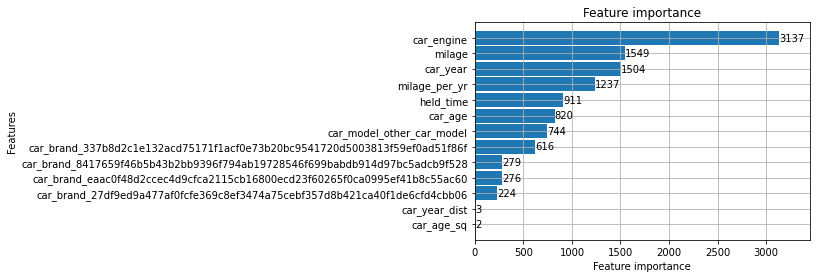

In [37]:
lgb.plot_importance(lgbr, max_num_features = 60, height=.9)

### Providing the original dataset with an additional column for the predicted value

In [44]:
price_orig = pd.read_csv("price.csv")

pred_all = rfr_reg.predict(x)

price_orig['predicted_price']=pred_all

# price_orig[0:5]

price_orig.to_csv('original_price_dataset_with_prediction.csv', index=False)

## Problem statement 1b. Price depreciation:

The price depreciation is the overtime value reduction of an asset, in this case, a vehicle. We can track and calculate the value depreciation using a regression model. 

We have already created our varaible "held_time" which represents the difference between sales date and purchase date in days. for simplicity for this model we will use 3 independant features. In order to handle the possible non linearities, we will use a random forest model but not something like a OLS regression. 



In [39]:
xtrain_dep = x[['car_engine','milage','held_time','car_year']]
ytrain_dep = y

rf_dep = RandomForestRegressor(n_estimators=100, random_state=_random_seed)
rf_dep.fit(xtrain_dep, ytrain_dep)

RandomForestRegressor(random_state=1234)

Now that we have a model with some important features in the model let us look at how the price changes with the "held time" feature as other variables are held constant. For this I create a dataset to predict with held-time variable varies from 0-100  and other variables held constant to isolate the effect of the depreciation.

In [67]:
car_engine = np.repeat(2.0, 21)
milage = np.repeat(80000, 21)
held_time = [0,5, 10,15, 20,25, 30,35, 40,45, 50,55, 60,65, 70,75, 80,85, 90,95, 100]
car_year = np.repeat(2016, 21)

df_dep = pd.DataFrame({'car_engine': car_engine,
                       'milage': milage,
                       'held_time': held_time,
                      'car_year': car_year})



df_dep['predicted_sale']= rf_dep.predict(df_dep)
df_dep

,car_engine,milage,held_time,car_year,predicted_sale
0,2.0,80000,0,2016,118589.0
1,2.0,80000,5,2016,118589.0
2,2.0,80000,10,2016,118589.0
3,2.0,80000,15,2016,118589.0
4,2.0,80000,20,2016,119633.0
5,2.0,80000,25,2016,116752.0
6,2.0,80000,30,2016,122589.0
7,2.0,80000,35,2016,115536.0
8,2.0,80000,40,2016,107994.0
9,2.0,80000,45,2016,100043.0


<AxesSubplot:xlabel='held_time', ylabel='predicted_sale'>

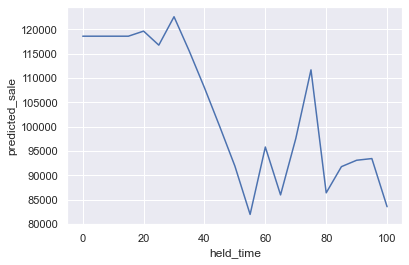

In [68]:
sns.set_theme(style="darkgrid")
sns.lineplot(data =df_dep, x='held_time', y='predicted_sale')

We see that the the price tends to change with the depreciation variable. The Y variable is RM and held time is in days. For example, in this graph, a car engine capacity of 2.0 and a car with milage of 80,000 the price of the car tends to deplete as the time goes on. The car if it was sold at the same day it was purchased can be sold for 120,000 but after 100 days it can only be sold for 85000. This model will help us predict the price based on depreciation.